In [1]:
import os
import numpy as np
import pandas as pd
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(style="darkgrid")
%matplotlib inline

In [2]:
sns.__version__

'0.9.0'

In [186]:
def load_data(mani_dir):
    paths = np.sort(np.array(os.listdir(mani_dir)))
    data = np.array([loadmat(mani_dir+path) for path in paths])
    return paths, data

def format_str(s0):
    s1 = ''
    counter = 0
    for l in s0:
        if l == '_':
            counter += 1
        if l == '_' and counter in [2,4,6] :
            l = '-'
        s1+=l
    return s1

def get_layer_type(path, types):
    for t in types:
        if t in path:
            return t

def frame_constructor(paths, data, key, tag=None, mean=False):
#     layers = [path.split('-')[1] for path in paths]
    perm_seed = [path.split('_')[0] for path in paths]
    ft_size = [path.split('_')[1] for path in paths]
    lnum = [path.split('_')[4] for path in paths]
    coding = [path.split('_')[3] for path in paths]
#     layers = np.array([format_str(path).split('_')[3] for path in paths])
#     epochs = np.array([int(format_str(path).split('_')[1].split('-')[1]) for path in paths])
    image_set = np.array([path.split('_')[0] for path in paths])
    
    data_vec = np.array([np.squeeze(datum[key]) for datum in data])
    if mean:
        data_vec = np.mean(data_vec,axis=1)
    data_vec = np.atleast_2d(data_vec)    
    print(data_vec.shape)
    if data_vec.shape[0]<data_vec.shape[1]:
        data_vec = data_vec.T
        
    df = pd.DataFrame(
        columns=[
            'path', 
            'image set', 
            'layer number',
            'coding',
            'perm seed', 
            'feature size', 
            'value', 
            'measure',
            'tag'
        ], 
        data=np.array([
            np.repeat([paths],data_vec.shape[-1],axis=0).T.reshape(-1),
            np.repeat([image_set],data_vec.shape[-1],axis=0).T.reshape(-1),
            np.repeat([lnum],data_vec.shape[-1],axis=0).T.reshape(-1),
            np.repeat([coding],data_vec.shape[-1],axis=0).T.reshape(-1),
            np.repeat([perm_seed],data_vec.shape[-1],axis=0).T.reshape(-1),
            np.repeat([ft_size],data_vec.shape[-1],axis=0).T.reshape(-1),
            data_vec.reshape(-1),
            np.repeat(key,data_vec.size),
            np.repeat(tag,data_vec.size)
        ]).T
    )
    
    types = ['MaxPool2d', 'Conv2d', 'ReLU', 'Linear', 'BatchNorm2d']
    df['type'] = df.path.apply(lambda x: get_layer_type(x, types))
    df['value'] = pd.to_numeric(df['value'], errors='coerce')
    df['perm seed'] = pd.to_numeric(df['perm seed'], errors='coerce')
    df['feature size'] = pd.to_numeric(df['feature size'], errors='coerce')
    df['layer number'] = pd.to_numeric(df['layer number'], errors='coerce')
    return df
  
## old
# def display(df, measure, coding, title, dims=(12,7)):
#     unique_tags = np.unique(df.tag.values)
#     data = df[
#         (df['measure']==measure) &
#         (df['coding']==coding)
#     ].sort_values(by=['layer number'])
#     print(data['layer number'])
#     fig, ax = plt.subplots(figsize=dims)

#     ax = sns.scatterplot(x="layer number", 
#                          y="value", 
#                          ax=ax,
#                          hue="tag",
#                          data=data)
#     ax.set_title(title)
#     ax.set_ylabel('mean {}'.format(measure.replace('_vec','')))
#     ax.set_xticks(ticks=range(len(data.type)/len(unique_tags)))
#     ax.set_xticklabels(data.type.values[::len(unique_tags)],rotation=90)
#     ax.set_xlabel('layer type')
    
def make_contiguous(a):
    return np.arange(len(a))
    
def display(df, measure, coding, title, dims=(12,7)):
    unique_tags = np.unique(df.tag.values)
    data = df[
        (df['measure']==measure) &
        (df['coding']==coding)
    ].sort_values(by=['layer number']).copy()
    
    for unique_tag in unique_tags:
        contiguous_layer_num = make_contiguous(data[data['tag']==unique_tag]['layer number'].values)
        data.loc[data['tag']==unique_tag, 'layer number'] = contiguous_layer_num
    
    # re sort by layer number, as everything will be shifted if one set was not contiguous
    data = data.sort_values(by=['layer number'])
    
    fig, ax = plt.subplots(figsize=dims)

    ax = sns.scatterplot(x="layer number", 
                         y="value", 
                         ax=ax,
                         hue="tag",
                         data=data)
    ax.set_title(title)
    ax.set_ylabel('mean {}'.format(measure.replace('_vec','')))
    ax.set_xticks(ticks=range(len(data.type)/len(unique_tags)))
    ax.set_xticklabels(data.type.values[::len(unique_tags)],rotation=90)
    ax.set_xlabel('layer type')
    return data

## plot manifold evolution across layers -- full manifolds

In [50]:
mani_dir = '../vgg-feature-gen/CIFAR100/vgg16_manifolds_full/'
paths, data = load_data(mani_dir)
paths = [path.replace('beta-softmax-ordered_','') for path in paths]

df = frame_constructor(paths, data, 'D_M_vec', tag='Full manifolds', mean=True)
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag='Full manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag='Full manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag='Full manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag='Full manifolds',))

df.tail()

(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)


,path,layer number,coding,perm seed,feature size,value,measure,tag,type
31,"train_ep_300_features_5_Conv2d64,_128,_kernel_...",5,features,NaN,NaN,0.241494,CCcorr,Full manifolds,Conv2d
32,train_ep_300_features_6_ReLUinplace.h5,6,features,NaN,NaN,0.241494,CCcorr,Full manifolds,ReLU
33,"train_ep_300_features_7_Conv2d128,_128,_kernel...",7,features,NaN,NaN,0.212942,CCcorr,Full manifolds,Conv2d
34,train_ep_300_features_8_ReLUinplace.h5,8,features,NaN,NaN,0.212942,CCcorr,Full manifolds,ReLU
35,train_ep_300_features_9_MaxPool2dkernel_size=2...,9,features,NaN,NaN,0.217558,CCcorr,Full manifolds,MaxPool2d


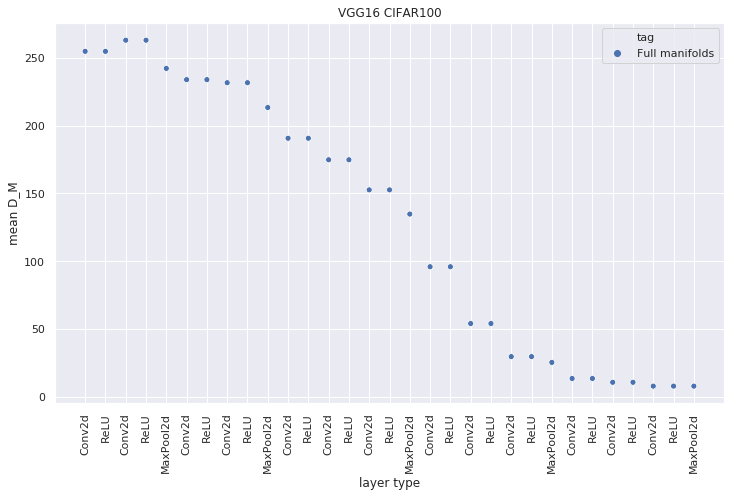

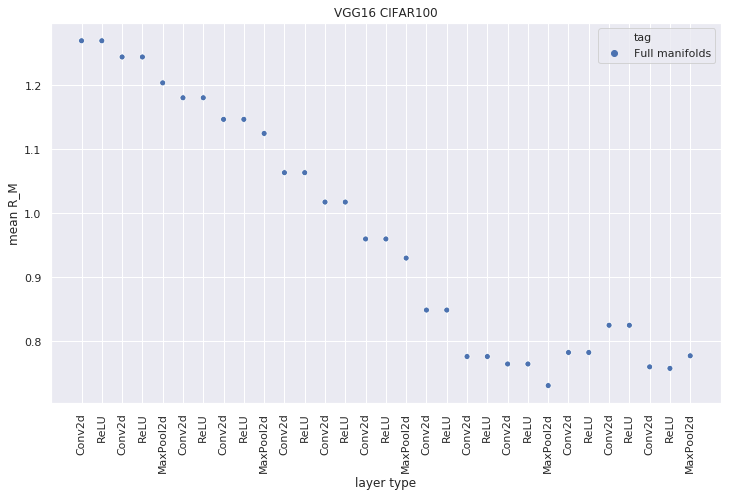

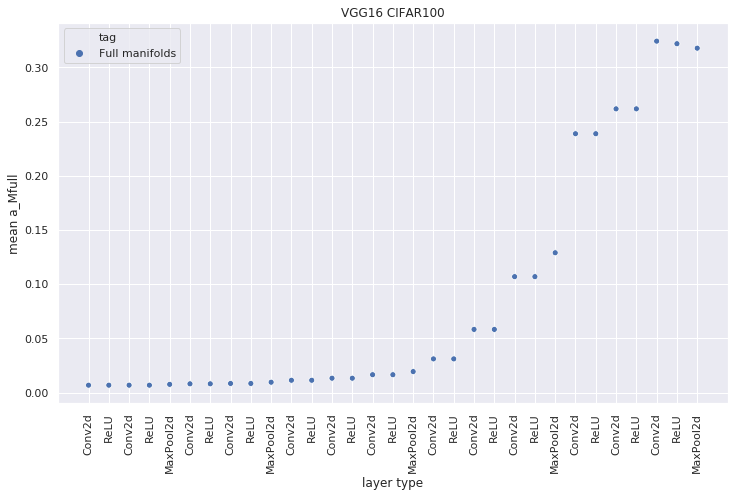

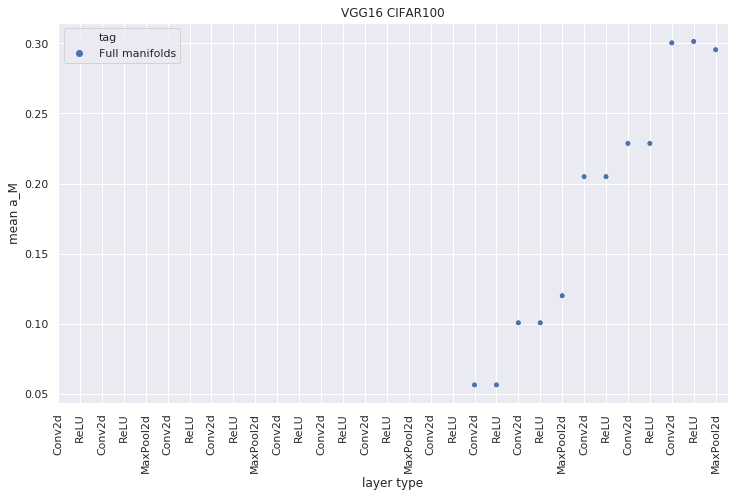

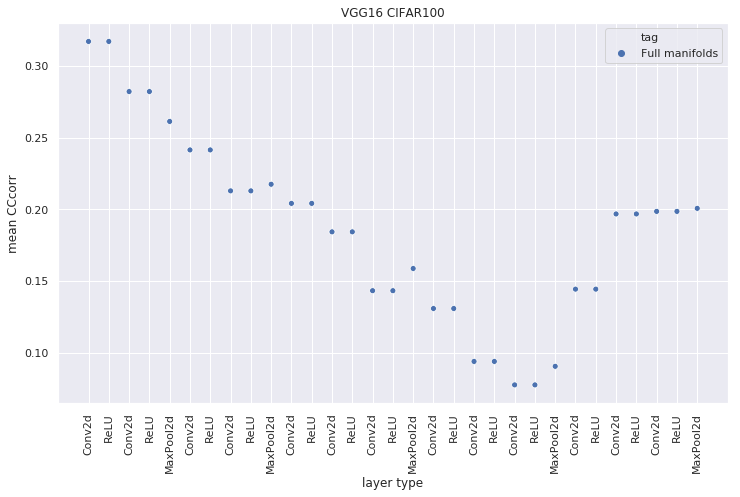

In [51]:
for v in ['D_M_vec','R_M_vec', 'a_Mfull_vec', 'a_M_vec', 'CCcorr']:
    display(df, v, 'features', 'VGG16 CIFAR100')

## plot manifold evolution across layers -- manifolds based on top 50 beta-softmax

In [54]:
mani_dir = '../vgg-feature-gen/CIFAR100/vgg16_manifolds_top50/'
paths, data = load_data(mani_dir)
paths = [path.replace('beta-softmax-ordered_','') for path in paths]

df = frame_constructor(paths, data, 'D_M_vec', mean=True)
df = df.append(frame_constructor(paths, data, 'R_M_vec', mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr'))
# df['m'] = df['feature size']
df.tail()

(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)


,path,layer number,coding,perm seed,feature size,value,measure,tag,type
31,"train_ep_300_features_5_Conv2d64,_128,_kernel_...",5,features,NaN,NaN,0.172332,CCcorr,None,Conv2d
32,train_ep_300_features_6_ReLUinplace.h5,6,features,NaN,NaN,0.172332,CCcorr,None,ReLU
33,"train_ep_300_features_7_Conv2d128,_128,_kernel...",7,features,NaN,NaN,0.141325,CCcorr,None,Conv2d
34,train_ep_300_features_8_ReLUinplace.h5,8,features,NaN,NaN,0.141325,CCcorr,None,ReLU
35,train_ep_300_features_9_MaxPool2dkernel_size=2...,9,features,NaN,NaN,0.153941,CCcorr,None,MaxPool2d


## MISSING features_20  

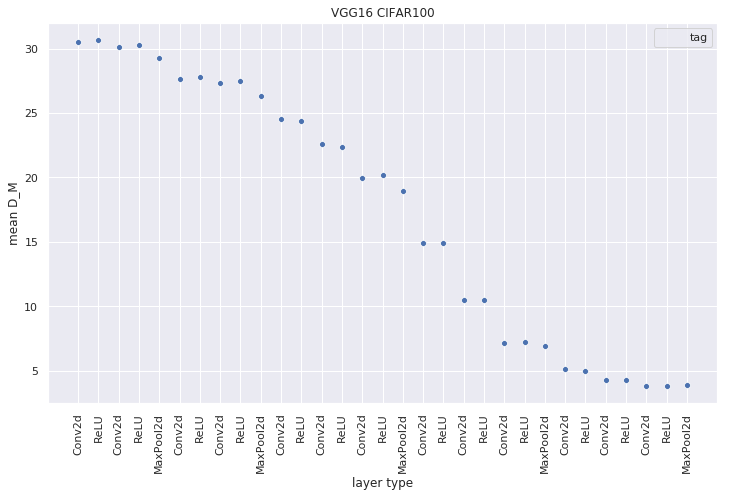

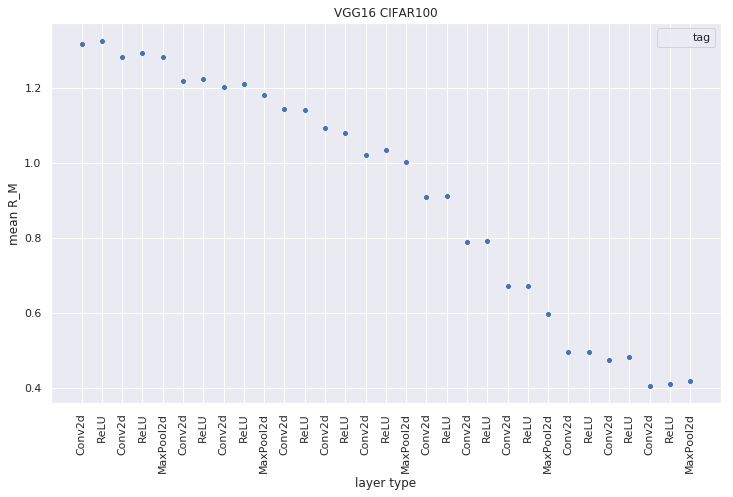

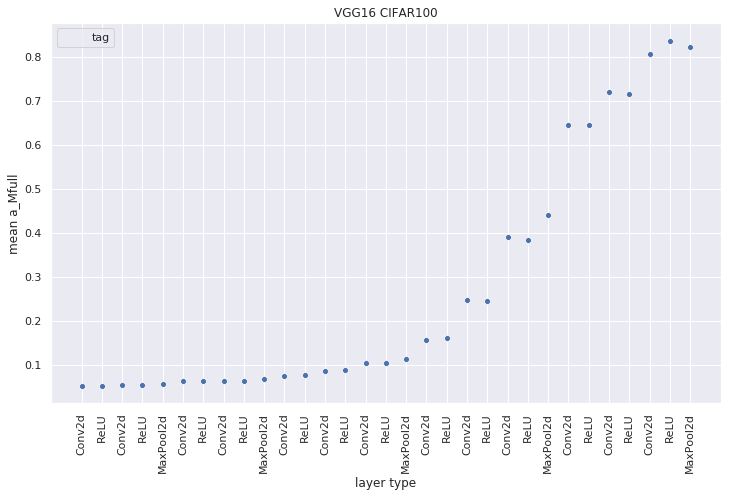

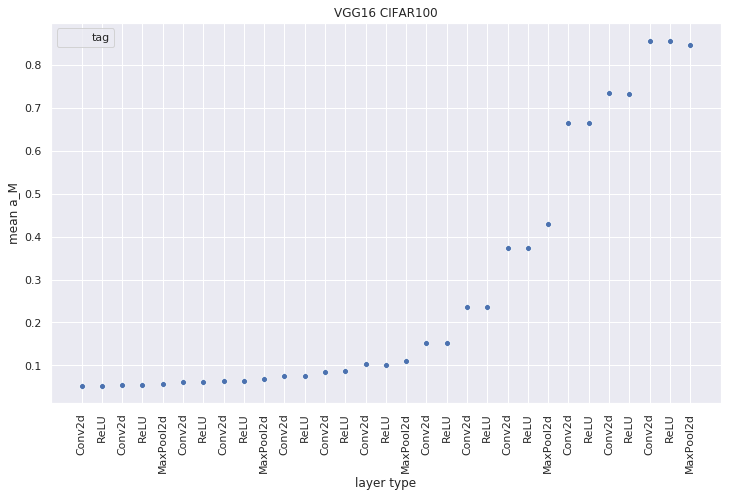

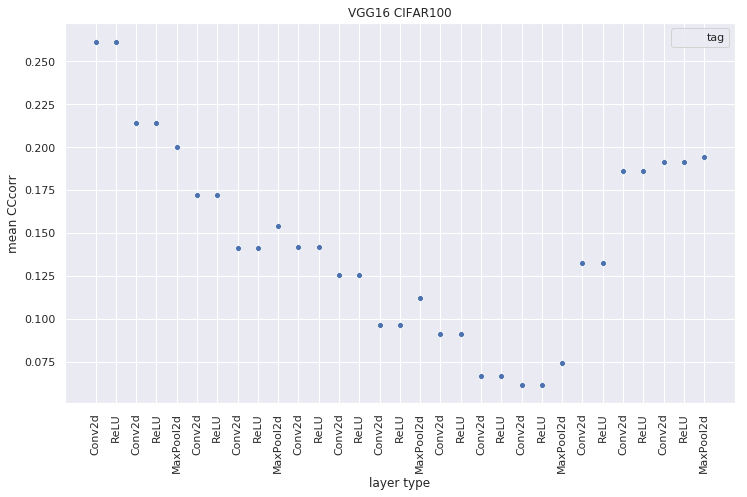

In [55]:
for v in ['D_M_vec','R_M_vec', 'a_Mfull_vec', 'a_M_vec', 'CCcorr']:
    display(df, v, 'features', 'VGG16 CIFAR100')

## plot overlaid 

(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)


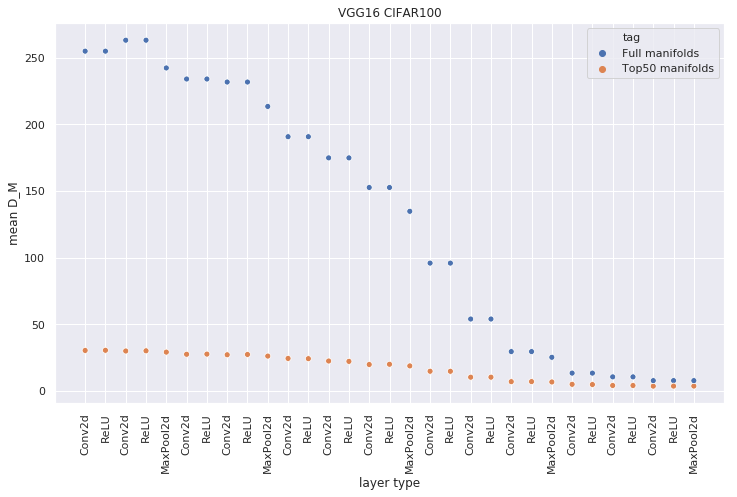

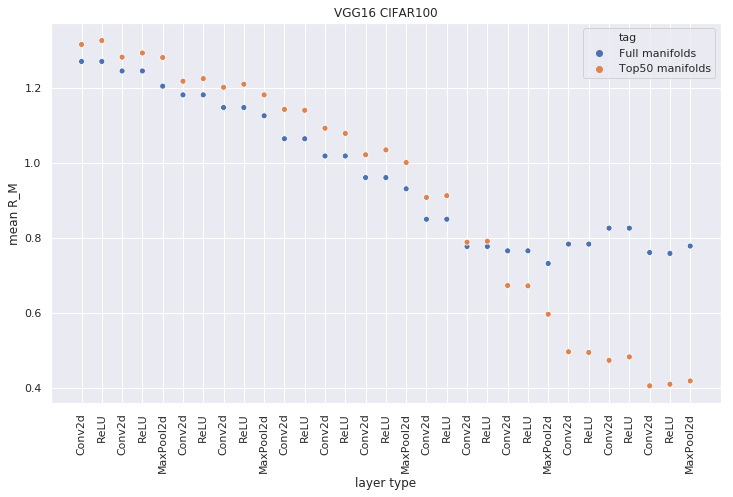

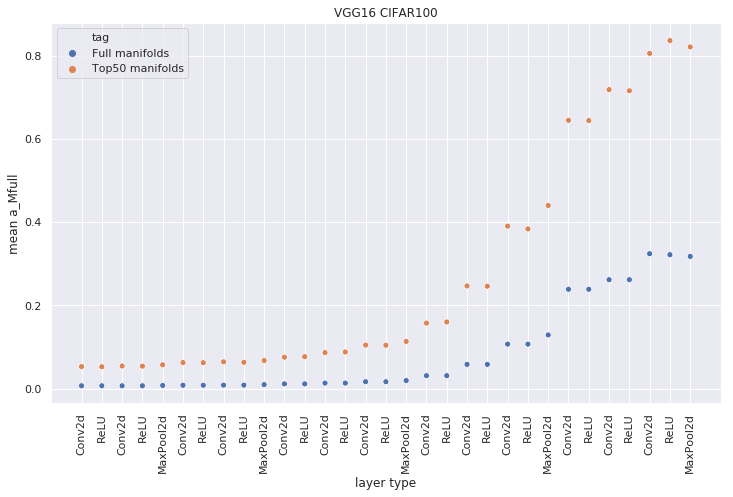

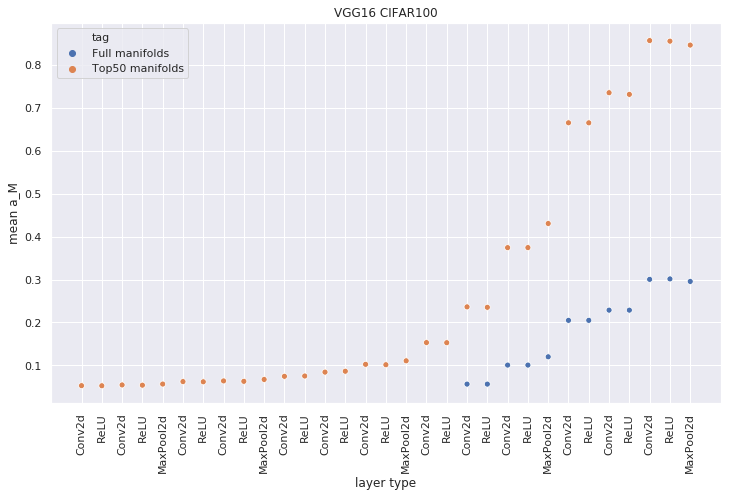

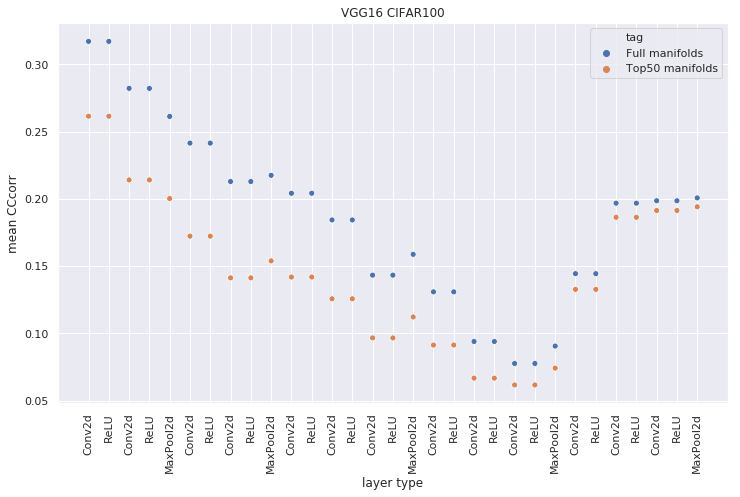

In [187]:
mani_dir = '../vgg-feature-gen/CIFAR100/vgg16_manifolds_full/'
paths, data = load_data(mani_dir)
paths = [path.replace('beta-softmax-ordered_','') for path in paths]

df = frame_constructor(paths, data, 'D_M_vec', tag='Full manifolds', mean=True)
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag='Full manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag='Full manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag='Full manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag='Full manifolds'))

mani_dir = '../vgg-feature-gen/CIFAR100/vgg16_manifolds_top50/'
paths, data = load_data(mani_dir)
paths = [path.replace('beta-softmax-ordered_','') for path in paths]

df = df.append(frame_constructor(paths, data, 'D_M_vec', tag='Top50 manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag='Top50 manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag='Top50 manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag='Top50 manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag='Top50 manifolds'))

for v in ['D_M_vec','R_M_vec', 'a_Mfull_vec', 'a_M_vec', 'CCcorr']:
    display(df, v, 'features', 'VGG16 CIFAR100')

## display lots of manifold measures

(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)


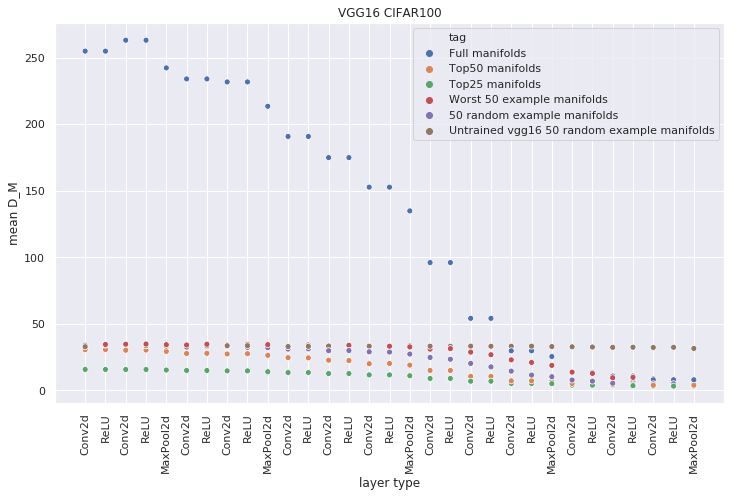

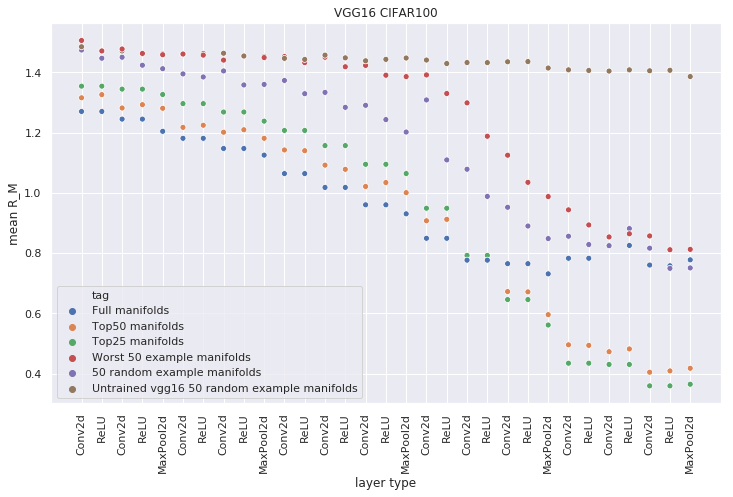

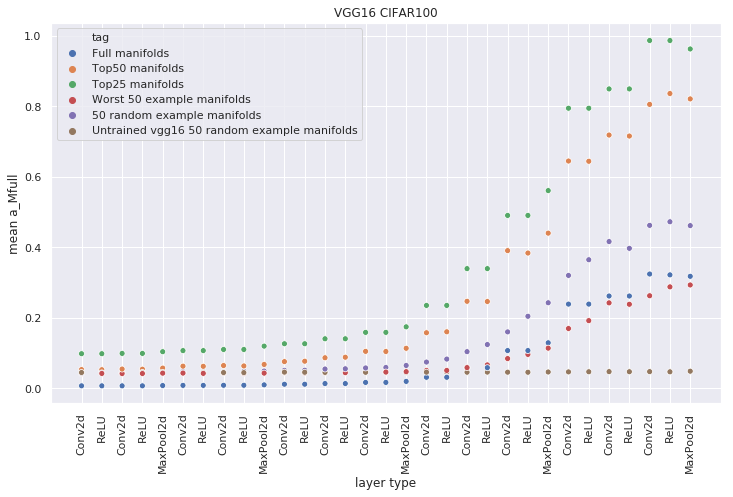

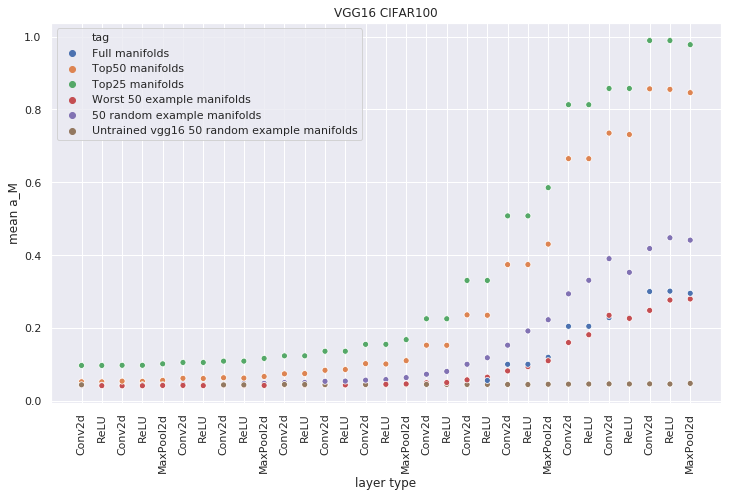

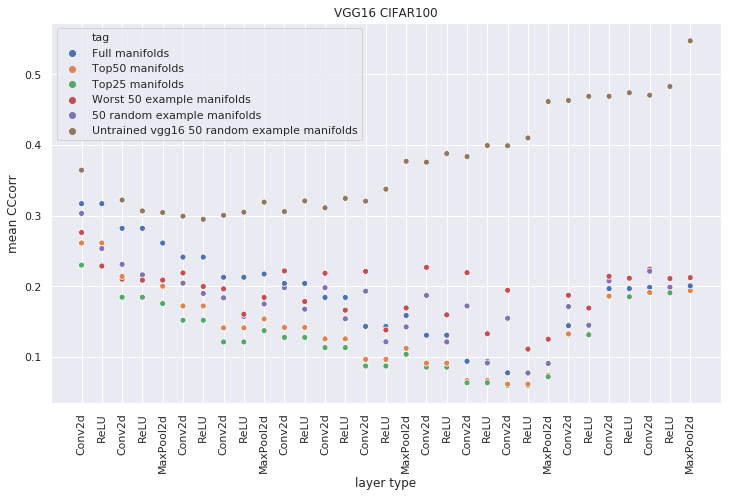

In [188]:
mani_dir = '../vgg-feature-gen/CIFAR100/vgg16_manifolds_full/'
paths, data = load_data(mani_dir)
paths = [path.replace('beta-softmax-ordered_','') for path in paths]

df = frame_constructor(paths, data, 'D_M_vec', tag='Full manifolds', mean=True)
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag='Full manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag='Full manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag='Full manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag='Full manifolds'))

mani_dir = '../vgg-feature-gen/CIFAR100/vgg16_manifolds_top50/'
paths, data = load_data(mani_dir)
paths = [path.replace('beta-softmax-ordered_','') for path in paths]

df = df.append(frame_constructor(paths, data, 'D_M_vec', tag='Top50 manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag='Top50 manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag='Top50 manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag='Top50 manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag='Top50 manifolds'))

mani_dir = '../vgg-feature-gen/CIFAR100/vgg16_manifolds_25/'
paths, data = load_data(mani_dir)
paths = [path.replace('beta-softmax-ordered_','') for path in paths]

df = df.append(frame_constructor(paths, data, 'D_M_vec', tag='Top25 manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag='Top25 manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag='Top25 manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag='Top25 manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag='Top25 manifolds'))

mani_dir = '../vgg-feature-gen/CIFAR100/manifold_vgg16_randperm_example_selection/'
paths, data = load_data(mani_dir)
paths = [path.replace('beta-softmax-ordered_','') for path in paths]

df = df.append(frame_constructor(paths, data, 'D_M_vec', tag='50 random example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag='50 random example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag='50 random example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag='50 random example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag='50 random example manifolds'))

mani_dir = '../vgg-feature-gen/CIFAR100/manifold_vgg16_reverse_bsoftmax_50/'
paths, data = load_data(mani_dir)
# paths = [path.replace('beta-softmax-ordered_','') for path in paths]

df = df.append(frame_constructor(paths, data, 'D_M_vec', tag='Worst 50 example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag='Worst 50 example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag='Worst 50 example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag='Worst 50 example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag='Worst 50 example manifolds'))


mani_dir = '../vgg-feature-gen/CIFAR100/manifold_feature_rand_vgg16_rand_example_seed1/'
paths, data = load_data(mani_dir)
# paths = [path.replace('beta-softmax-ordered_','') for path in paths]

df = df.append(frame_constructor(paths, data, 'D_M_vec', tag='Untrained vgg16 50 random example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag='Untrained vgg16 50 random example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag='Untrained vgg16 50 random example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag='Untrained vgg16 50 random example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag='Untrained vgg16 50 random example manifolds'))

for v in ['D_M_vec','R_M_vec', 'a_Mfull_vec', 'a_M_vec', 'CCcorr']:
    display(df, v, 'features', 'VGG16 CIFAR100')

## best, worst, full

(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)


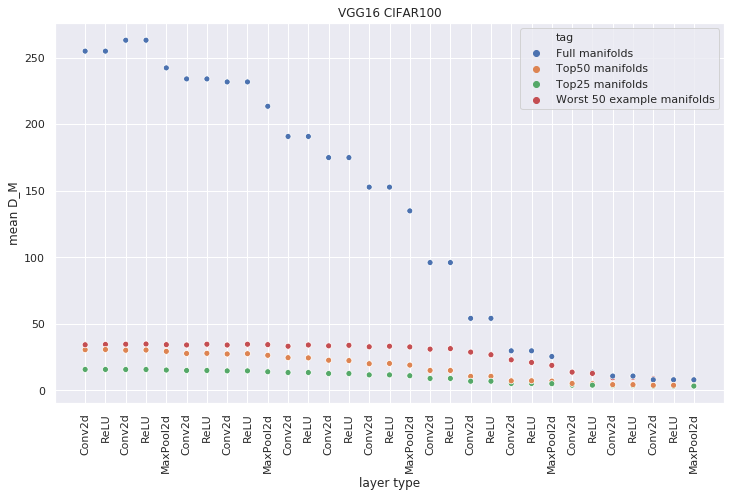

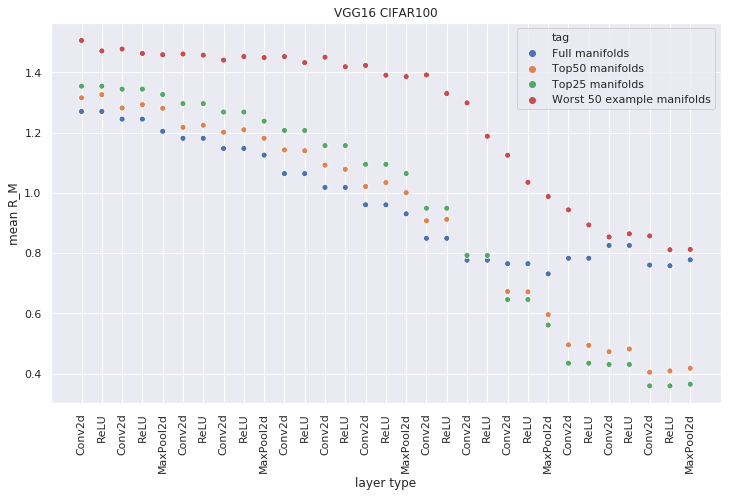

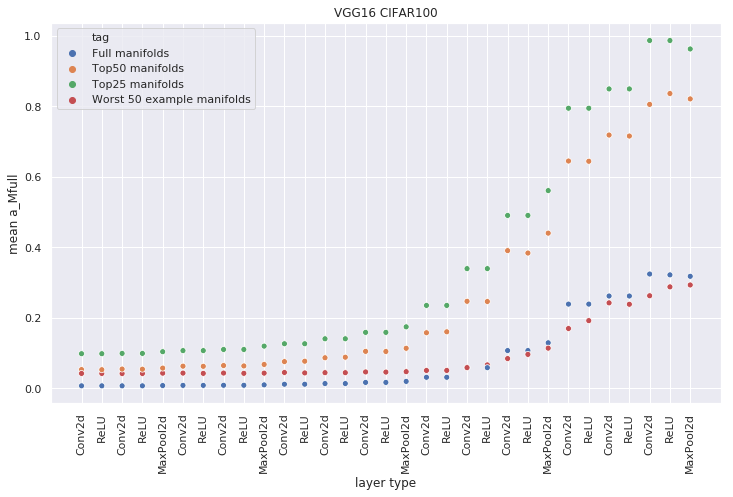

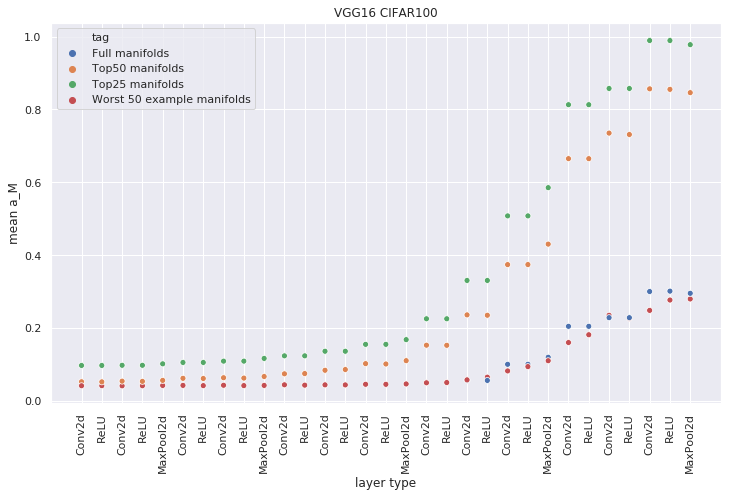

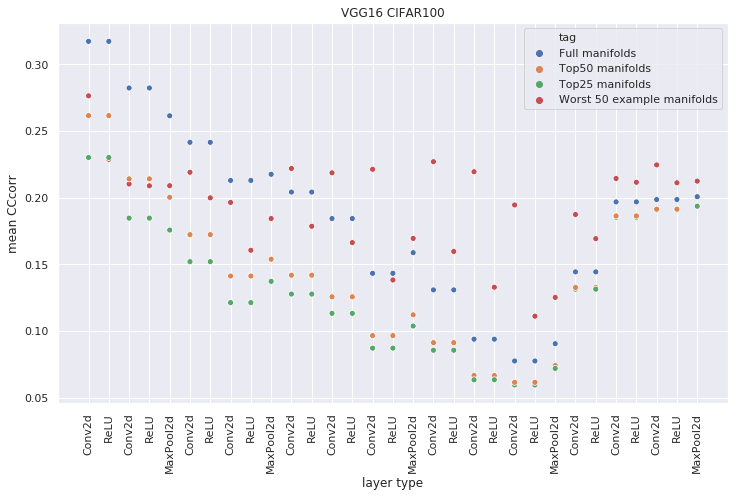

In [189]:
mani_dir = '../vgg-feature-gen/CIFAR100/vgg16_manifolds_full/'
paths, data = load_data(mani_dir)
paths = [path.replace('beta-softmax-ordered_','') for path in paths]

df = frame_constructor(paths, data, 'D_M_vec', tag='Full manifolds', mean=True)
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag='Full manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag='Full manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag='Full manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag='Full manifolds'))

mani_dir = '../vgg-feature-gen/CIFAR100/vgg16_manifolds_top50/'
paths, data = load_data(mani_dir)
paths = [path.replace('beta-softmax-ordered_','') for path in paths]

df = df.append(frame_constructor(paths, data, 'D_M_vec', tag='Top50 manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag='Top50 manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag='Top50 manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag='Top50 manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag='Top50 manifolds'))

mani_dir = '../vgg-feature-gen/CIFAR100/vgg16_manifolds_25/'
paths, data = load_data(mani_dir)
paths = [path.replace('beta-softmax-ordered_','') for path in paths]

df = df.append(frame_constructor(paths, data, 'D_M_vec', tag='Top25 manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag='Top25 manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag='Top25 manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag='Top25 manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag='Top25 manifolds'))

mani_dir = '../vgg-feature-gen/CIFAR100/manifold_vgg16_reverse_bsoftmax_50/'
paths, data = load_data(mani_dir)
# paths = [path.replace('beta-softmax-ordered_','') for path in paths]

df = df.append(frame_constructor(paths, data, 'D_M_vec', tag='Worst 50 example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag='Worst 50 example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag='Worst 50 example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag='Worst 50 example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag='Worst 50 example manifolds'))

for v in ['D_M_vec','R_M_vec', 'a_Mfull_vec', 'a_M_vec', 'CCcorr']:
    display(df, v, 'features', 'VGG16 CIFAR100')

## best, worst, random, untrained

(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)


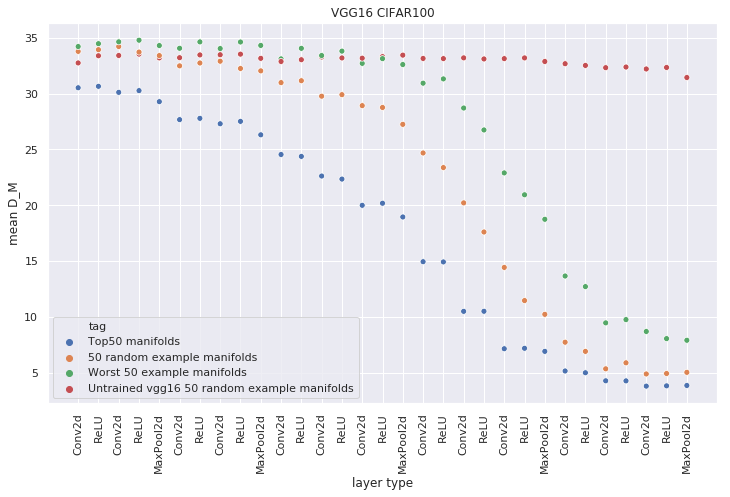

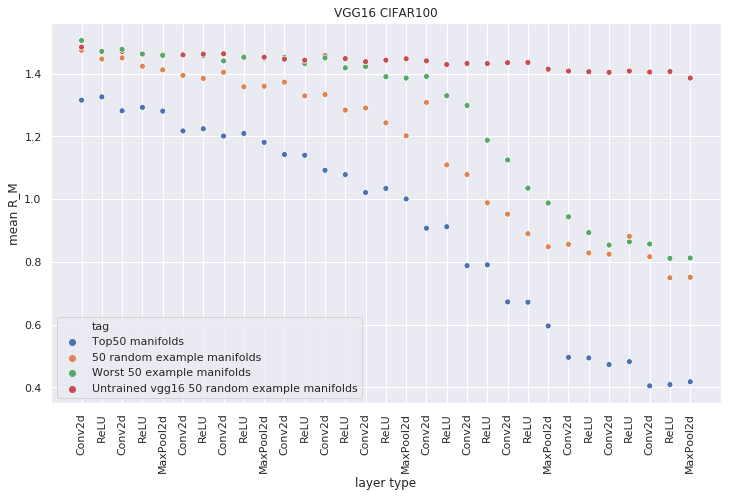

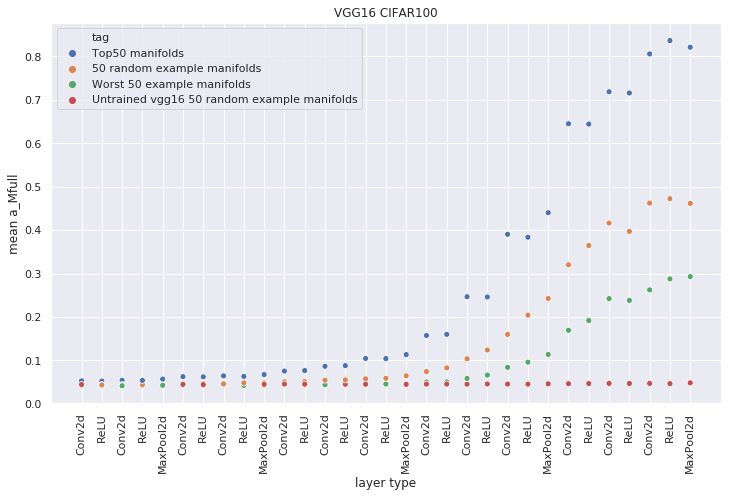

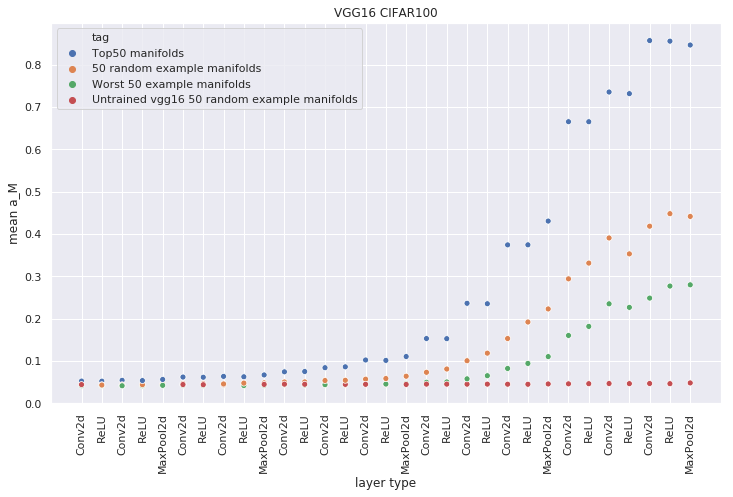

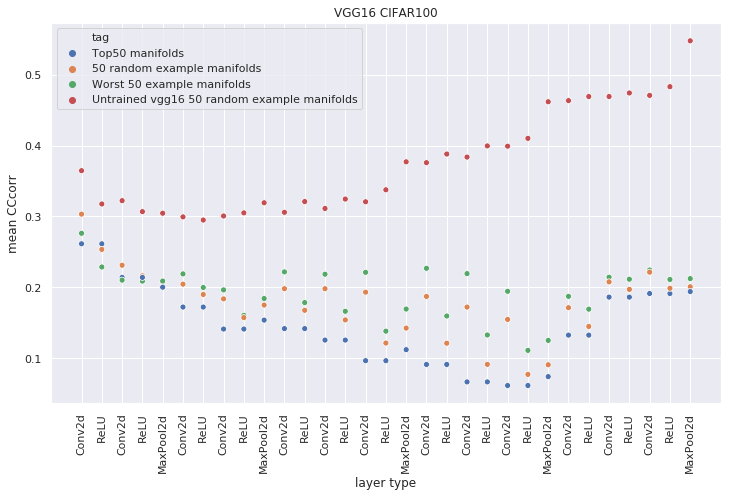

In [190]:
mani_dir = '../vgg-feature-gen/CIFAR100/vgg16_manifolds_top50/'
paths, data = load_data(mani_dir)
paths = [path.replace('beta-softmax-ordered_','') for path in paths]

df = frame_constructor(paths, data, 'D_M_vec', tag='Top50 manifolds', mean=True)
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag='Top50 manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag='Top50 manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag='Top50 manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag='Top50 manifolds'))

mani_dir = '../vgg-feature-gen/CIFAR100/manifold_vgg16_randperm_example_selection/'
paths, data = load_data(mani_dir)
paths = [path.replace('beta-softmax-ordered_','') for path in paths]

df = df.append(frame_constructor(paths, data, 'D_M_vec', tag='50 random example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag='50 random example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag='50 random example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag='50 random example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag='50 random example manifolds'))

mani_dir = '../vgg-feature-gen/CIFAR100/manifold_vgg16_reverse_bsoftmax_50/'
paths, data = load_data(mani_dir)
# paths = [path.replace('beta-softmax-ordered_','') for path in paths]

df = df.append(frame_constructor(paths, data, 'D_M_vec', tag='Worst 50 example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag='Worst 50 example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag='Worst 50 example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag='Worst 50 example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag='Worst 50 example manifolds'))


mani_dir = '../vgg-feature-gen/CIFAR100/manifold_feature_rand_vgg16_rand_example_seed1/'
paths, data = load_data(mani_dir)
# paths = [path.replace('beta-softmax-ordered_','') for path in paths]

df = df.append(frame_constructor(paths, data, 'D_M_vec', tag='Untrained vgg16 50 random example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag='Untrained vgg16 50 random example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag='Untrained vgg16 50 random example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag='Untrained vgg16 50 random example manifolds', mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag='Untrained vgg16 50 random example manifolds'))

for v in ['D_M_vec','R_M_vec', 'a_Mfull_vec', 'a_M_vec', 'CCcorr']:
    display(df, v, 'features', 'VGG16 CIFAR100')

## train vs val -- no dropout, no batchnorm

(1, 71)
(1, 71)
(1, 71)
(1, 71)
(1, 71)


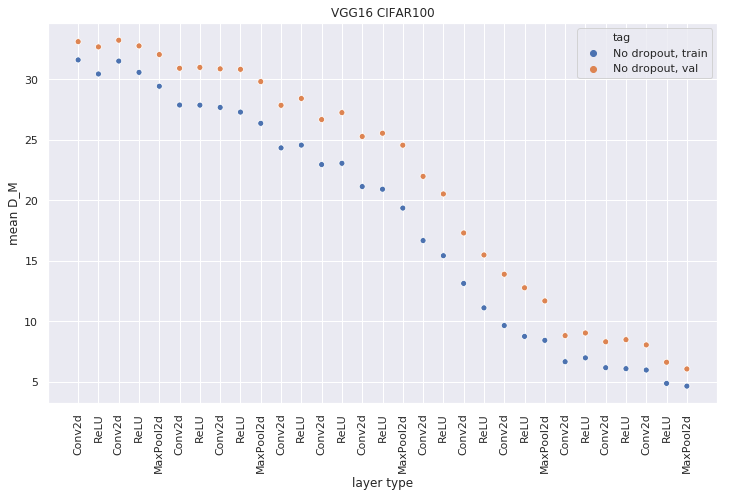

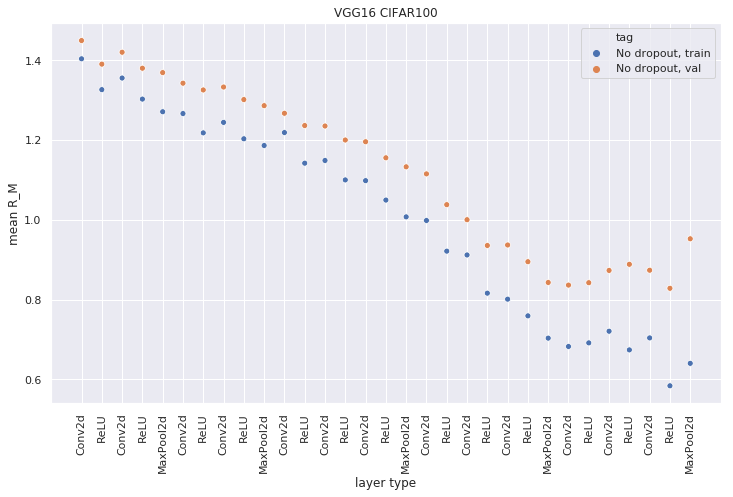

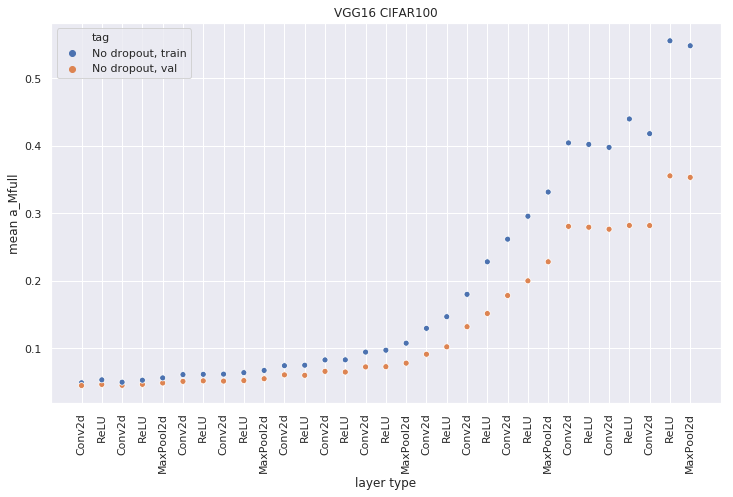

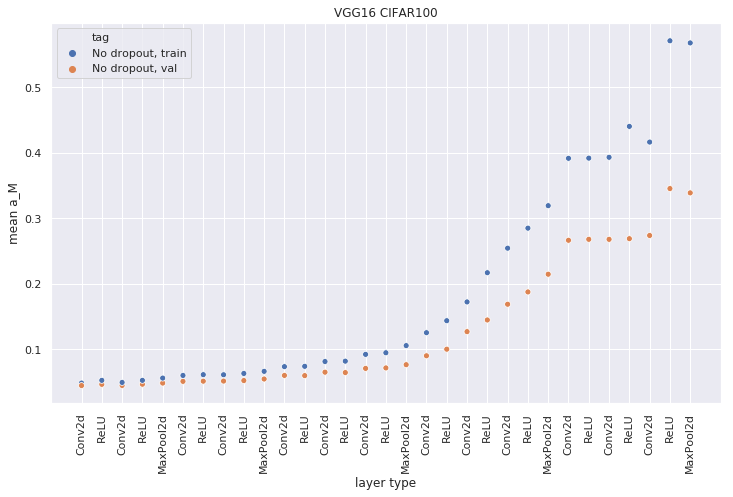

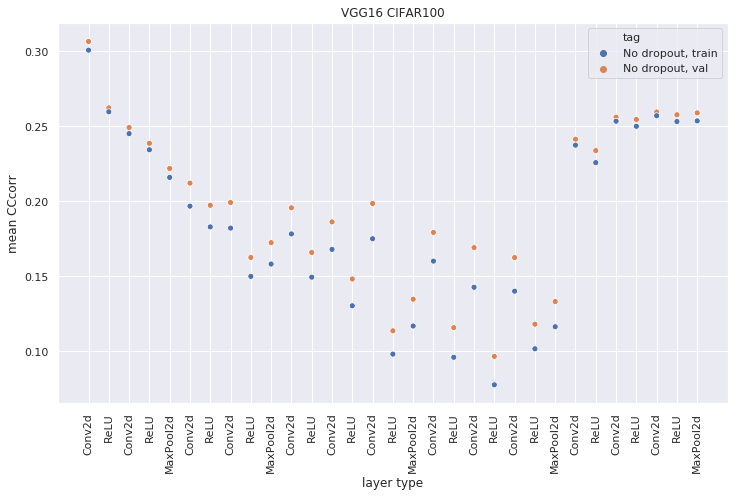

In [134]:
mani_dir = '../vgg-feature-gen/CIFAR100/manifold_formatted_drop_0_feature_vgg16_seed0/'
paths, data = load_data(mani_dir)

tag = 'No dropout, '
df = frame_constructor(paths, data, 'D_M_vec', tag=tag, mean=True)
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag=tag))

df['tag'] = df['tag']+df['image set']

for v in ['D_M_vec','R_M_vec', 'a_Mfull_vec', 'a_M_vec', 'CCcorr']:
    display(df, v, 'features', 'VGG16 CIFAR100')

## dropout effect on features -- train

(1, 71)
(1, 71)
(1, 71)
(1, 71)
(1, 71)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 71)
(1, 71)
(1, 71)
(1, 71)
(1, 71)


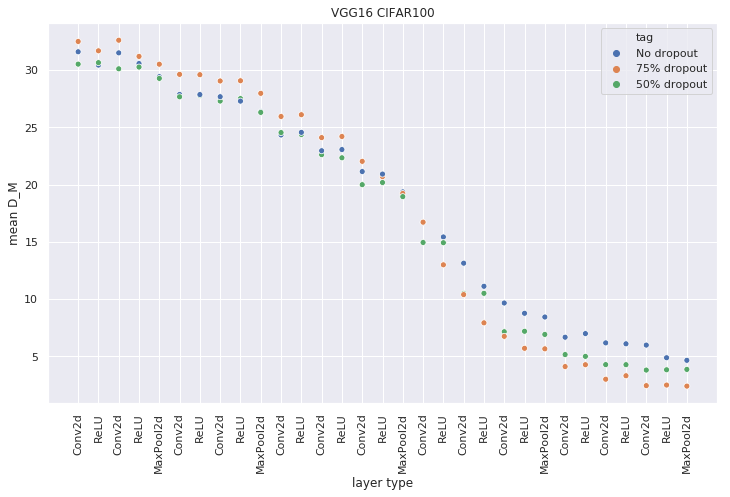

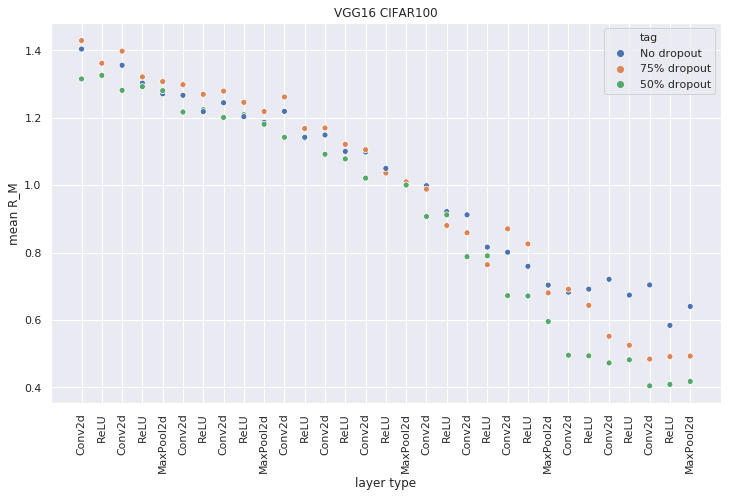

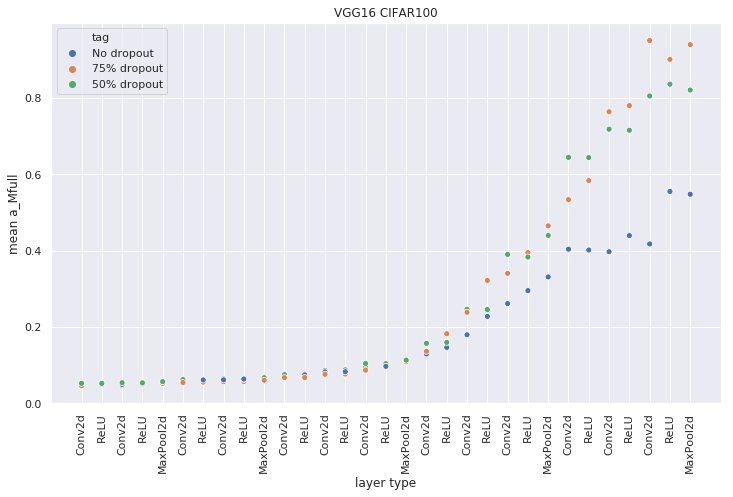

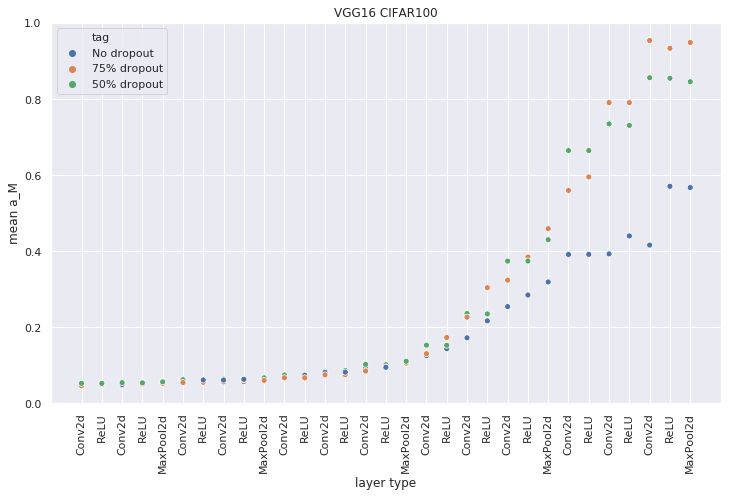

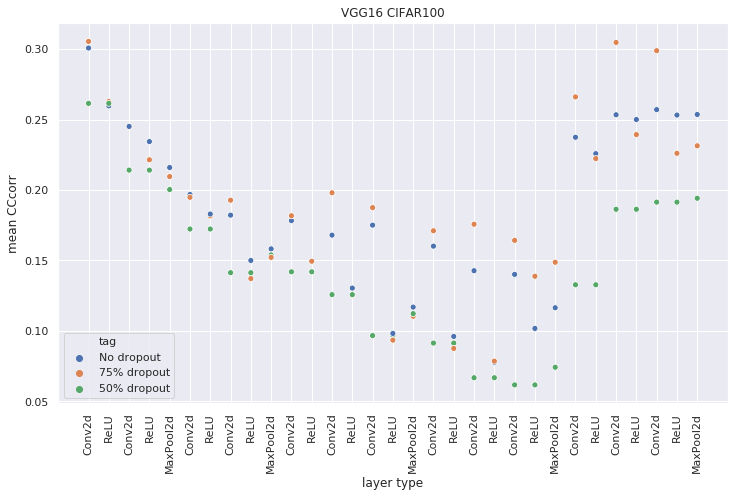

In [164]:
mani_dir = '../vgg-feature-gen/CIFAR100/manifold_formatted_drop_0_feature_vgg16_seed0/'
paths, data = load_data(mani_dir)

tag = 'No dropout'
df = frame_constructor(paths, data, 'D_M_vec', tag=tag, mean=True)
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag=tag))

# #### something wrong with drop 25???
# mani_dir = '../vgg-feature-gen/CIFAR100/manifold_formatted_drop_25_feature_vgg16_seed0/'
# paths, data = load_data(mani_dir)

# tag = '25% dropout'
# df = df.append(frame_constructor(paths, data, 'D_M_vec', tag=tag, mean=True))
# df = df.append(frame_constructor(paths, data, 'R_M_vec', tag=tag, mean=True))
# df = df.append(frame_constructor(paths, data, 'a_M_vec', tag=tag, mean=True))
# df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag=tag, mean=True))
# df = df.append(frame_constructor(paths, data, 'CCcorr', tag=tag))

mani_dir = '../vgg-feature-gen/CIFAR100/vgg16_manifolds_top50/'
paths, data = load_data(mani_dir)
paths = [path.replace('beta-softmax-ordered_','') for path in paths]

tag = '50% dropout'
df = df.append(frame_constructor(paths, data, 'D_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag=tag))


mani_dir = '../vgg-feature-gen/CIFAR100/manifold_formatted_drop_75_feature_vgg16_seed0/'
paths, data = load_data(mani_dir)

tag = '75% dropout'
df = df.append(frame_constructor(paths, data, 'D_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag=tag))


df_filtered = df[df['image set']=='train']

for v in ['D_M_vec','R_M_vec', 'a_Mfull_vec', 'a_M_vec', 'CCcorr']:
    display(df_filtered, v, 'features', 'VGG16 CIFAR100')

## dropout effect on features -- validation

(1, 71)
(1, 71)
(1, 71)
(1, 71)
(1, 71)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 71)
(1, 71)
(1, 71)
(1, 71)
(1, 71)


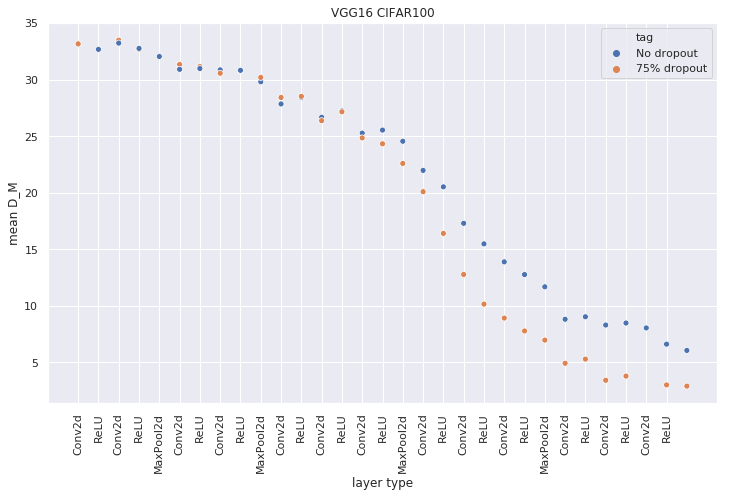

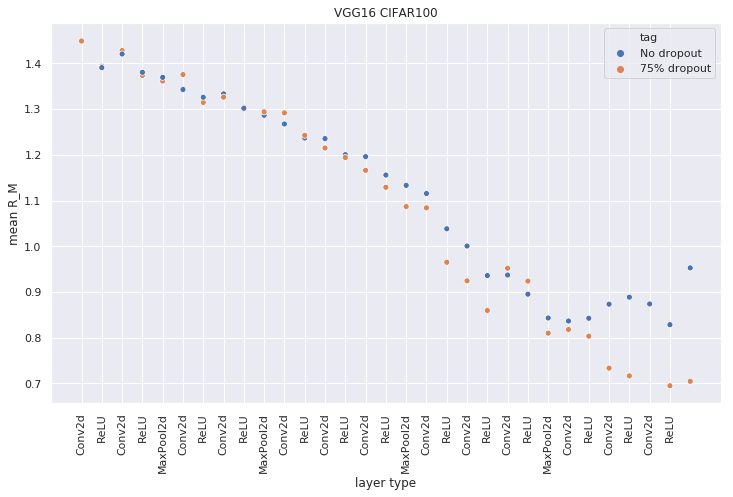

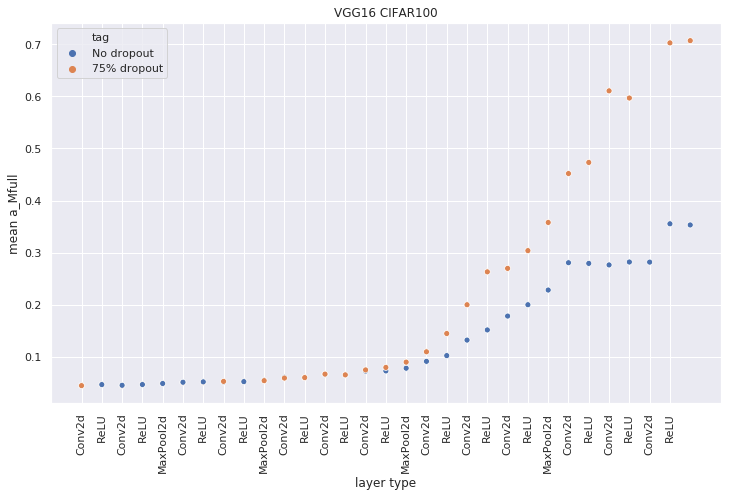

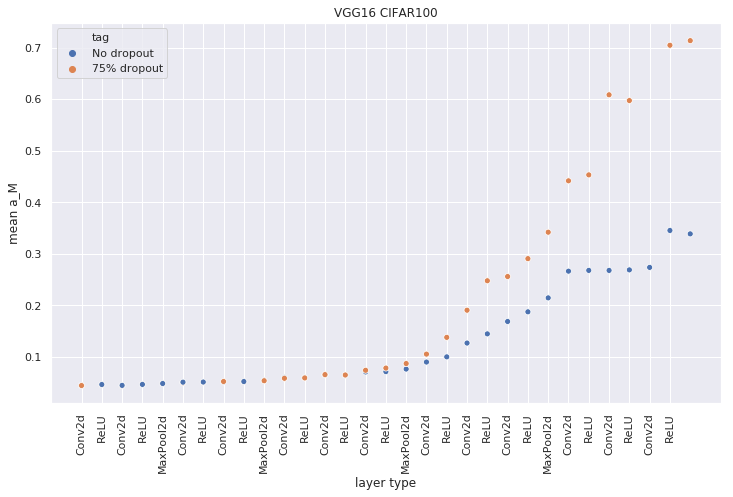

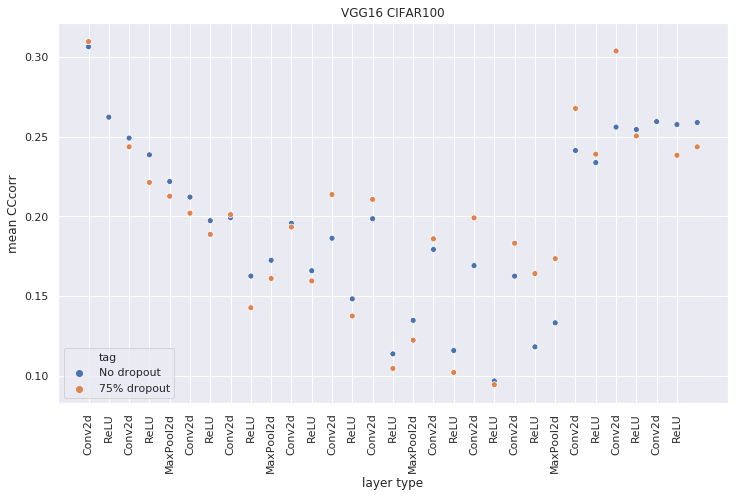

In [167]:
mani_dir = '../vgg-feature-gen/CIFAR100/manifold_formatted_drop_0_feature_vgg16_seed0/'
paths, data = load_data(mani_dir)

tag = 'No dropout'
df = frame_constructor(paths, data, 'D_M_vec', tag=tag, mean=True)
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag=tag))

#### something wrong with drop 25???
# mani_dir = '../vgg-feature-gen/CIFAR100/manifold_formatted_drop_25_feature_vgg16_seed0/'
# paths, data = load_data(mani_dir)

# tag = '25% dropout'
# df = df.append(frame_constructor(paths, data, 'D_M_vec', tag=tag, mean=True))
# df = df.append(frame_constructor(paths, data, 'R_M_vec', tag=tag, mean=True))
# df = df.append(frame_constructor(paths, data, 'a_M_vec', tag=tag, mean=True))
# df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag=tag, mean=True))
# df = df.append(frame_constructor(paths, data, 'CCcorr', tag=tag))

mani_dir = '../vgg-feature-gen/CIFAR100/vgg16_manifolds_top50/'
paths, data = load_data(mani_dir)
paths = [path.replace('beta-softmax-ordered_','') for path in paths]

tag = '50% dropout'
df = df.append(frame_constructor(paths, data, 'D_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag=tag))


mani_dir = '../vgg-feature-gen/CIFAR100/manifold_formatted_drop_75_feature_vgg16_seed0/'
paths, data = load_data(mani_dir)

tag = '75% dropout'
df = df.append(frame_constructor(paths, data, 'D_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag=tag))


df_filtered = df[df['image set']=='val']

for v in ['D_M_vec','R_M_vec', 'a_Mfull_vec', 'a_M_vec', 'CCcorr']:
    display(df_filtered, v, 'features', 'VGG16 CIFAR100')

## dropout effect on classifier

## a look at batchnorm -- needs further analysis??

(1, 98)
(1, 98)
(1, 98)
(1, 98)
(1, 98)
(1, 98)
(1, 98)
(1, 98)
(1, 98)
(1, 98)


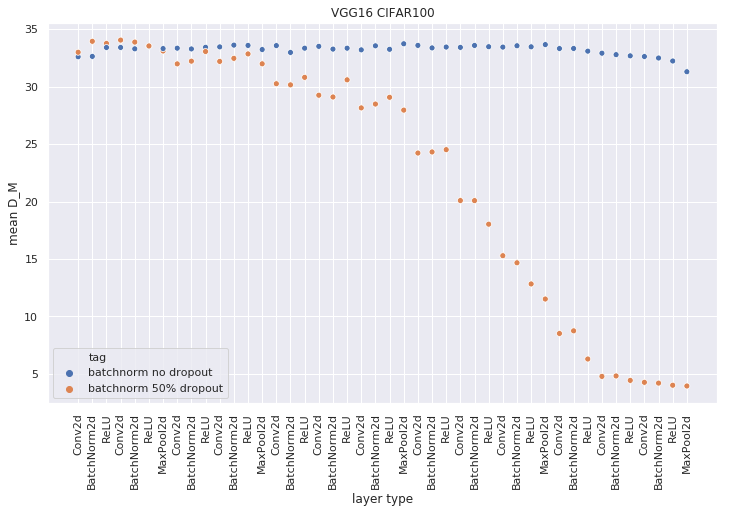

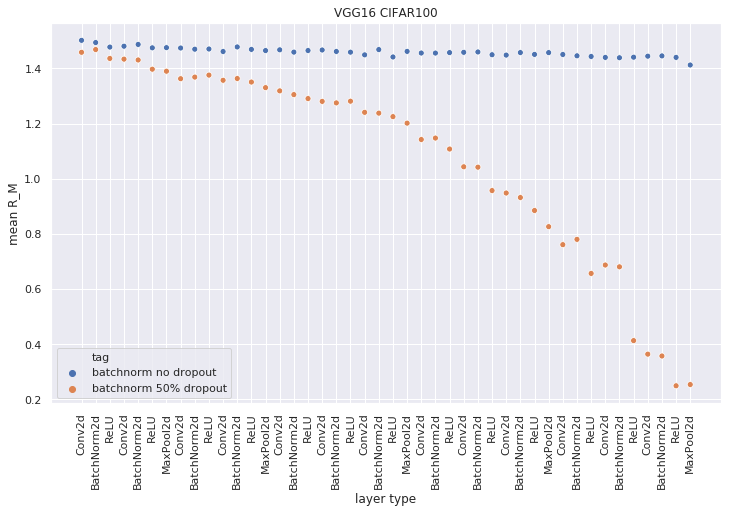

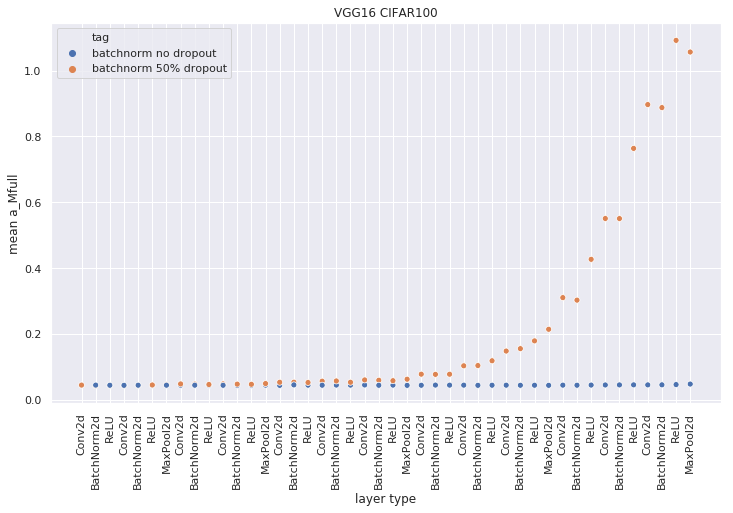

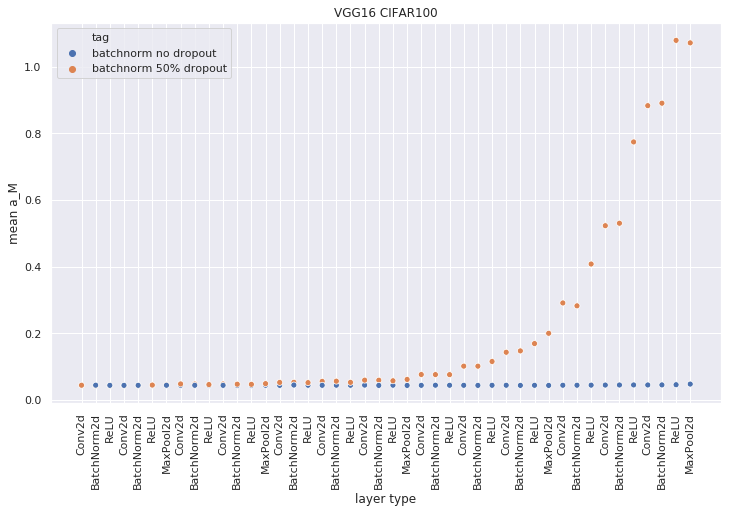

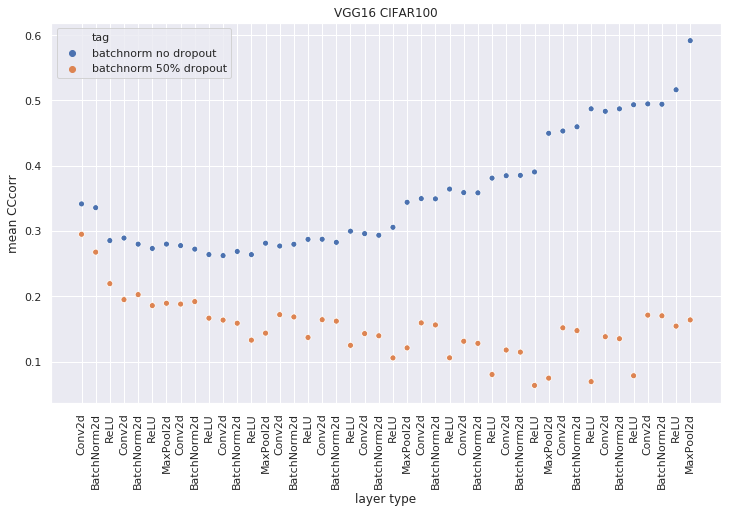

In [191]:

## looks like there is an issue with drop 0 as well??
mani_dir = '../vgg-feature-gen/CIFAR100/manifold_formatted_drop_0_feature_vgg16_bn_seed0/'
paths, data = load_data(mani_dir)

tag = 'batchnorm no dropout'
df = frame_constructor(paths, data, 'D_M_vec', tag=tag, mean=True)
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag=tag))

mani_dir = '../vgg-feature-gen/CIFAR100/manifold_formatted_drop_50_feature_vgg16_bn_seed0/'
paths, data = load_data(mani_dir)

tag = 'batchnorm 50% dropout'
df = df.append(frame_constructor(paths, data, 'D_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag=tag))

df_filtered = df[df['image set']=='train']

for v in ['D_M_vec','R_M_vec', 'a_Mfull_vec', 'a_M_vec', 'CCcorr']:
    display(df_filtered, v, 'features', 'VGG16 CIFAR100')

(1, 98)
(1, 98)
(1, 98)
(1, 98)
(1, 98)
(1, 36)
(1, 36)
(1, 36)
(1, 36)
(1, 36)


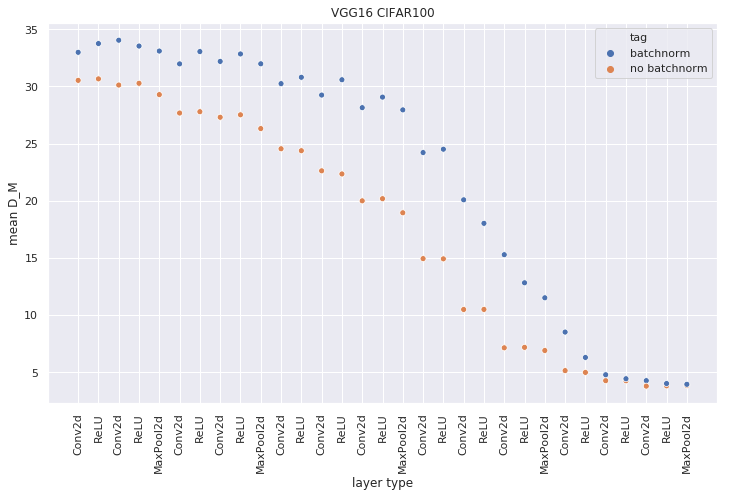

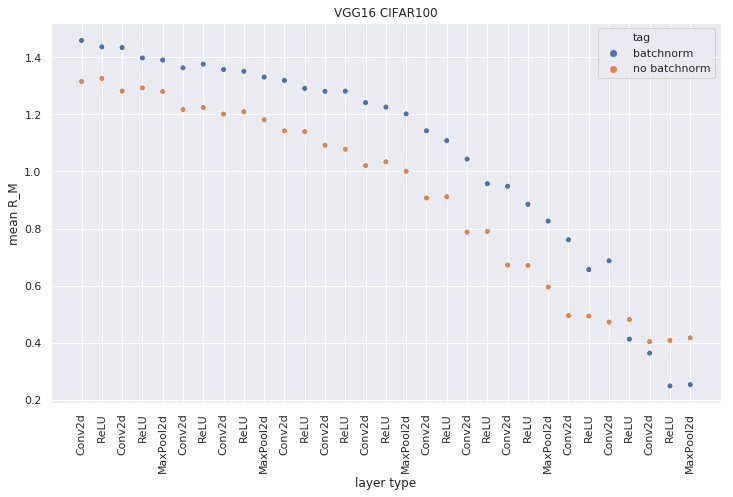

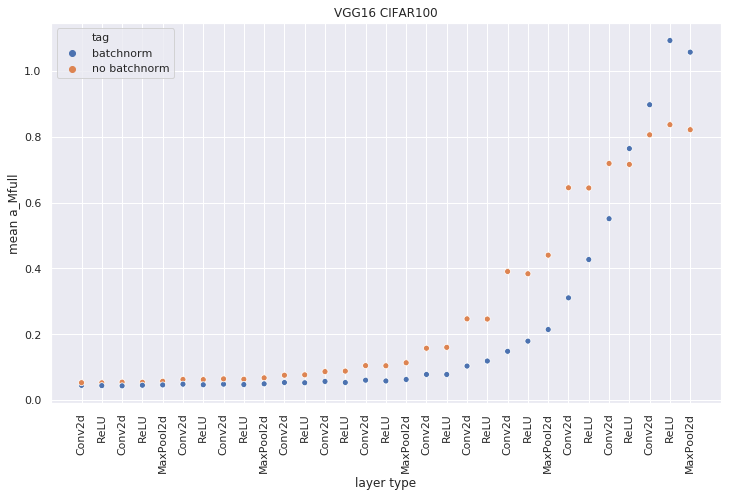

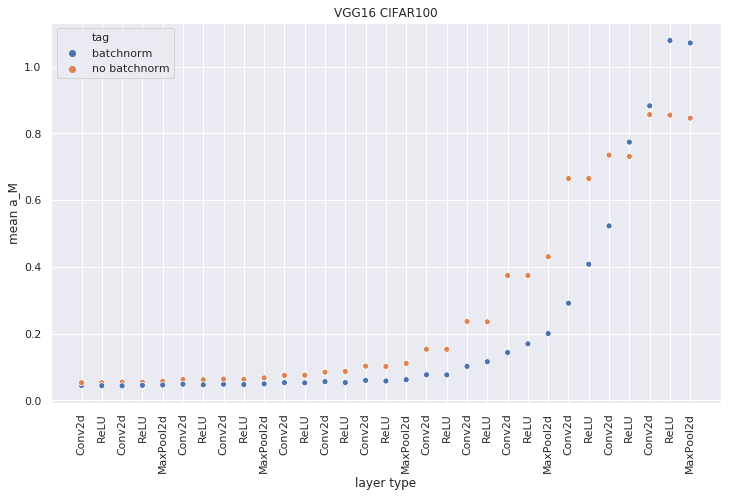

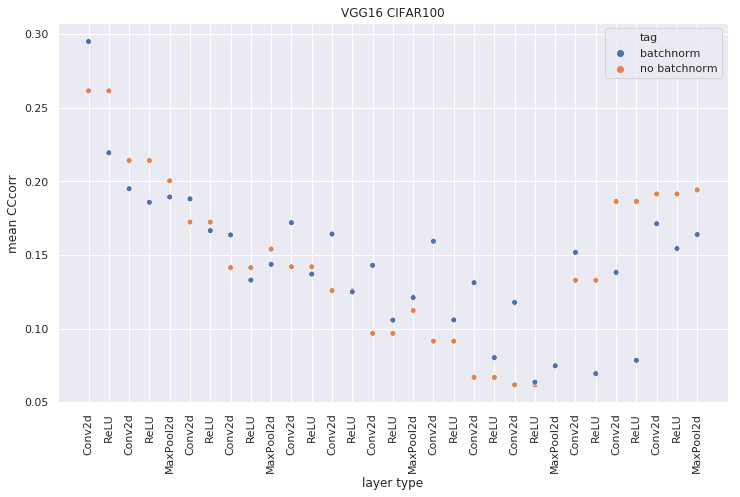

In [192]:
mani_dir = '../vgg-feature-gen/CIFAR100/manifold_formatted_drop_50_feature_vgg16_bn_seed0/'
paths, data = load_data(mani_dir)

tag = 'batchnorm'
df = frame_constructor(paths, data, 'D_M_vec', tag=tag, mean=True)
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag=tag))

mani_dir = '../vgg-feature-gen/CIFAR100/vgg16_manifolds_top50/'
paths, data = load_data(mani_dir)
paths = [path.replace('beta-softmax-ordered_','') for path in paths]

tag = 'no batchnorm'
df = df.append(frame_constructor(paths, data, 'D_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'R_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_M_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'a_Mfull_vec', tag=tag, mean=True))
df = df.append(frame_constructor(paths, data, 'CCcorr', tag=tag))

df_filtered = df[(df['image set']=='train')&(df['type']!='BatchNorm2d')]

for v in ['D_M_vec','R_M_vec', 'a_Mfull_vec', 'a_M_vec', 'CCcorr']:
    display(df_filtered, v, 'features', 'VGG16 CIFAR100')

## capacity vs accuracy

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30]


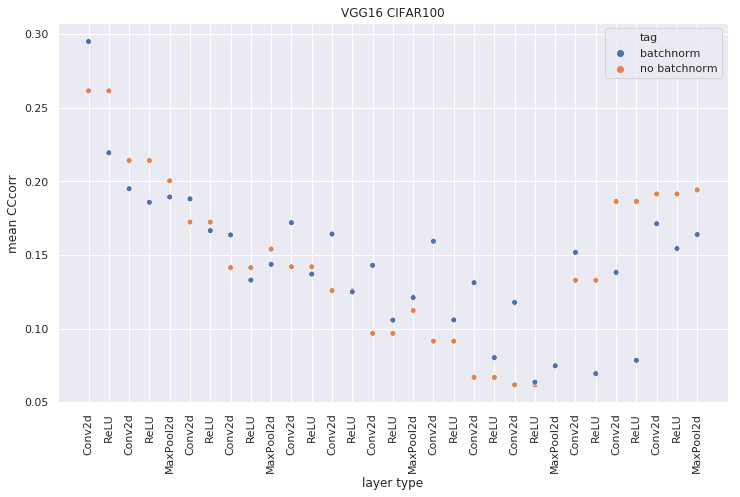

In [183]:
def display(df, measure, coding, title, dims=(12,7)):
    unique_tags = np.unique(df.tag.values)
    data = df[
        (df['measure']==measure) &
        (df['coding']==coding)
    ].sort_values(by=['layer number']).copy()
    
    for unique_tag in unique_tags:
        contiguous_layer_num = make_contiguous(data[data['tag']==unique_tag]['layer number'].values)
        print(contiguous_layer_num)
        data.loc[data['tag']==unique_tag, 'layer number'] = contiguous_layer_num
    
    # re sort by layer number, as everything will be shifted if one set was not contiguous
    data = data.sort_values(by=['layer number'])
    
    fig, ax = plt.subplots(figsize=dims)

    ax = sns.scatterplot(x="layer number", 
                         y="value", 
                         ax=ax,
                         hue="tag",
                         data=data)
    ax.set_title(title)
    ax.set_ylabel('mean {}'.format(measure.replace('_vec','')))
    ax.set_xticks(ticks=range(len(data.type)/len(unique_tags)))
    ax.set_xticklabels(data.type.values[::len(unique_tags)],rotation=90)
    ax.set_xlabel('layer type')
    return data
    
data = display(df_filtered, v, 'features', 'VGG16 CIFAR100')

In [182]:
data

,path,image set,layer number,coding,perm seed,feature size,value,measure,tag,type
5,"train_ep_300_features_0_Conv2d3,_64,_kernel_si...",train,0,features,NaN,NaN,0.295026,CCcorr,batchnorm,Conv2d
5,"train_ep_300_features_0_Conv2d3,_64,_kernel_si...",train,0,features,NaN,NaN,0.261487,CCcorr,no batchnorm,Conv2d
16,train_ep_300_features_1_ReLUinplace.h5,train,1,features,NaN,NaN,0.261487,CCcorr,no batchnorm,ReLU
27,"train_ep_300_features_2_Conv2d64,_64,_kernel_s...",train,2,features,NaN,NaN,0.214119,CCcorr,no batchnorm,Conv2d
27,train_ep_300_features_2_ReLUinplace.h5,train,1,features,NaN,NaN,0.219398,CCcorr,batchnorm,ReLU
29,train_ep_300_features_3_ReLUinplace.h5,train,3,features,NaN,NaN,0.214119,CCcorr,no batchnorm,ReLU
38,"train_ep_300_features_3_Conv2d64,_64,_kernel_s...",train,2,features,NaN,NaN,0.194952,CCcorr,batchnorm,Conv2d
30,train_ep_300_features_4_MaxPool2dkernel_size=2...,train,4,features,NaN,NaN,0.200335,CCcorr,no batchnorm,MaxPool2d
31,"train_ep_300_features_5_Conv2d64,_128,_kernel_...",train,5,features,NaN,NaN,0.172332,CCcorr,no batchnorm,Conv2d
44,train_ep_300_features_5_ReLUinplace.h5,train,3,features,NaN,NaN,0.185765,CCcorr,batchnorm,ReLU
